In [1]:
import numpy as np
import emcee
import corner

from nevin import nevin as Nevin

In [2]:
# -- plotting --
import matplotlib as mpl 
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# Example 0: Fitting a line to data 
generate fake data with Gaussian noise

In [3]:
theta_true = [-1., 0.5]

In [4]:
def model(theta, x): 
    '''forward model
    '''
    return theta[0] * x + theta[1]

In [5]:
N_data = 50

np.random.seed(0)
sig_noise = 1.
x_data = 10.*np.random.uniform(size=N_data)-5.
y_data =  model(theta_true, x_data) + sig_noise * np.random.randn(N_data)

Text(0, 0.5, 'y')

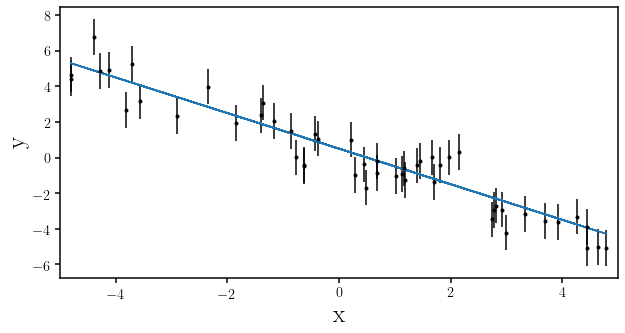

In [6]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(x_data, model(theta_true, x_data), c='C0')
sub.errorbar(x_data, y_data, yerr=np.repeat(sig_noise, N_data), fmt='.k')
sub.set_xlabel('x', fontsize=25)
sub.set_xlim(-5, 5)
sub.set_ylabel('y', fontsize=25)

In [7]:
prior_lim = [(-5., 0.5), [-0.5, 1.]]

In [8]:
def lnlikelihood(theta): 
    ''' gaussian likelihood
    '''
    y_model = model(theta, x_data)
    
    chi2 = (y_model - y_data)**2/sig_noise**2
    lnlike = -0.5 * (np.sum(chi2) + np.log(2.*np.pi*sig_noise**2))

    return lnlike

def lnprior(theta): 
    '''flat prior
    '''    
    m, b = theta
    if prior_lim[0][0] < m < prior_lim[0][1] and prior_lim[1][0] < b < prior_lim[1][1]:
        return 0.0
    return -np.inf

def lnposterior(theta): 
    return lnlikelihood(theta) + lnprior(theta)

flat priors

In [9]:
N_prior = 10000
prior_sample = np.array([np.random.uniform(lim[0], lim[1], size=N_prior) for lim in prior_lim]).T

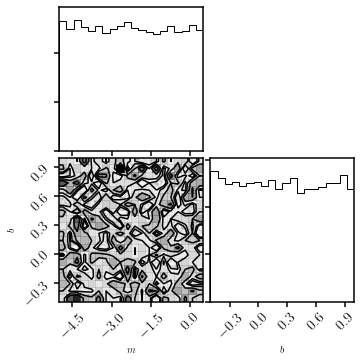

In [10]:
fig = corner.corner(prior_sample, labels=['$m$', '$b$'])

In [11]:
from scipy.optimize import minimize

nll = lambda *args: -lnlikelihood(*args)
initial = np.array(theta_true) + 0.1 * np.random.randn(2)

soln = minimize(nll, initial)
theta_ml = soln.x

In [12]:
pos = soln.x + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior)
sampler.run_mcmc(pos, 5000, progress=True)

100%|██████████| 5000/5000 [00:04<00:00, 1122.37it/s]


State([[-1.01025482  0.56456999]
 [-0.89318298  0.17611647]
 [-1.13955161  0.21102697]
 [-1.13560065  0.39143464]
 [-0.93348624  0.47611649]
 [-1.10642636  0.33165833]
 [-0.96794802  0.30656821]
 [-0.98670548  0.284901  ]
 [-1.08447668  0.20016627]
 [-1.11401183  0.14980375]
 [-1.03983219  0.63325852]
 [-1.02882481  0.37210257]
 [-1.05224768  0.4216469 ]
 [-1.00093563  0.32348325]
 [-1.11229774  0.48064671]
 [-1.10798651  0.36423377]
 [-1.01468156  0.26722031]
 [-0.93982058  0.11917793]
 [-1.0741168   0.22864271]
 [-1.0420392   0.22224343]
 [-1.12906246  0.50346604]
 [-0.94582303  0.27603939]
 [-1.04567762  0.31494246]
 [-0.99323189  0.31952345]
 [-1.02425024  0.48978364]
 [-1.16732219  0.46146581]
 [-1.14744728  0.57319035]
 [-1.10274578  0.28049961]
 [-1.05418475  0.42505034]
 [-1.00141192  0.22789524]
 [-0.95747907  0.39086072]
 [-1.02209757  0.54624909]], log_prob=[-23.74418581 -26.12012889 -25.21965641 -24.34927947 -24.81531074
 -23.40193121 -23.03942673 -22.70149313 -23.47771327 

In [13]:
chain = sampler.get_chain(discard=100, thin=15, flat=True)

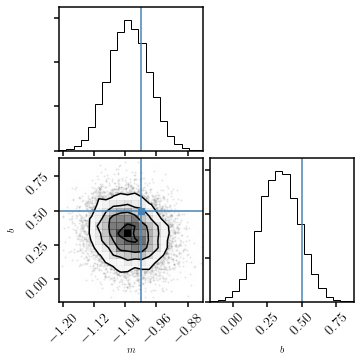

In [14]:
fig = corner.corner(chain, labels=['$m$', '$b$'], truths=theta_true)

In [15]:
lnlike_chain = np.array([lnlikelihood(tt) for tt in chain])

In [16]:
Nevin.log_evidence(chain, lnlike_chain, prior_sample)

-18.970278034297692